# Safe Reinforcement Learning via Shielding

A Jupyter Notebook by Carl Hildberandt

This Jupyter notebook is a description of how the self-driving car code works. The original paper ["Safe Reinforcement Learning via Shielding"](https://arxiv.org/abs/1708.08611) is by: **Mohammed Alshiekh, Roderick Bloem, Ruediger Ehlers, Bettina Könighofer, Scott Niekum, Ufuk Topcu**. The original code can be found in their [github repo](https://github.com/safe-rl/safe-rl-shielding).

## Setup

This notebook was tested on a clean install of Ubuntu 18.04. Place this notebook inside the `envs/self-driving-car` folder.

### Install Dependencies
Install the dependencies (Note: requirements.txt is given inside their repo):
```
$ sudo apt-get install python3-pip
$ sudo apt-get install cmake
$ sudo apt-get install swig
$ sudo apt install python3-notebook jupyter jupyter-core python-ipykernel
$ pip3 install jupyter
$ pip3 install matplotlib
$ pip3 install -r requirements.txt
```

### Changes to Codebase

The following is a list of changes made to the [original code base](https://github.com/safe-rl/safe-rl-shielding).

I removed all the `sleep(...)` commands from the code by replacing them with a `pass` command. This speeds up the visualization of the code.

Inside `util.py` I changed the `get_updates` command to work when no constraints and loss are passed. This is because when no shielding happens both the constraints and loss are none. Therefor change the line:

```
def get_updates(self, params, constraints, loss):
```

to:

```
def get_updates(self, params, constraints=None, loss=None):
```

Inside `krl.py` we need to update the big negative reward to have no shield:

```
elif not args.shield and args.big_neg:
    shield = Shield()
```

to:

```
elif not args.shield and args.big_neg:
    shield = None
```

### Running the Python Code

You can then run their python code using:

```
# No Shield
$ python3 krl.py -v

# Big Negative Reward
$ python3 krl.py -v -bn

# Preemtive Shield
$ python3 krl.py -v -p

# Post Shield
$ python3 krl.py -v -s
```

## Understanding the Paper

This Jupyter notebook will be split into three sections to explain each of the sections of the paper. The sections are:
* The Environment
* Reinforcement Learning
* Shielding

After which all sections will be put together so that the basic essence of the paper is shown

## Environment

The paper describes four environments, namely:
* Water Tank
* Grid World
* Self-Driving Car
* Seaquest

This Jupyter notebook is aimed at showing you how the **self-driving** car was implemented. I selected the self-driving car as it was the most interesting for my research, and it had all the elements to describe the paper.

### Setup
First import common libraries needed by most python project

In [1]:
%matplotlib inline
# Used to clear the display
from IPython.display import clear_output
# Used for displaying
import matplotlib.pyplot as plt
# Used for efficient matrix math
import numpy as np
# Used to enumerate integers into human readable form
import enum
# Used to do basic math operations
import math

Next, we will load the environment from their road environment. We give the environment a name and give it a flag to visualize it. We reset the environment to make sure everything is ready.

In [2]:
# Load environment Library
from env_road3 import Env 
# Launch environment
env = Env(env_label="Car Environment", viz=True)
# Reset environment
env.reset()

filling background
filling obstacles


array([ 0.16666667,  0.83333333,  0.62426595, -0.78121189])

The environment takes an integer as an input. The integers represent directions we want the vehicle to drive in. Below is a list of each of the inputs that they represent in degrees, as well as what they represent in cardinal directions. I used this table to create an enumeration of directions for later easier use and understanding:

| Input (integer) | Degree | Cardinal Directon |
| --- | --- | --- |
| 0 | 180 | South |
| 1 | 135 | South East |
| 2 | 90 | East |
| 3 | 45 | North East |
| 4 | 0 | North |
| 5 | 315 | North West |
| 6 | 270 | West |
| 7 | 225 | South West |


In [3]:
# Create an enum containing the directions
class Directions(enum.Enum):
    S = 0
    SE = 1
    E = 2
    NE = 3
    N = 4
    NW = 5
    W = 6
    SW = 7

This function returns a direction key given a value. Used later on to extract what the value of an input is

In [4]:
def get_direction_from_value(value):
    for key in Directions:
        if key.value == value:
            return key

### Testing the Environment

First, let us see how this environment works. Let us select a random action like "Drive East" and pass that to the environment. You will notice that the environment returns four values. The values are:

* **Observation**: These are values describing the status of the car, similar to sensors on a real self-driving car
* **r**: This is the reward generated by the environment
* **done**: This tells us if we have crashed or reached the maximum number of steps
* **info**: Other information about the behavior of the car

In [5]:
# Select an action
action = Directions.N.value
# Do that action in the environment
observation, r, done, info = env.step(action)
# Show reward and observation
print("Observation: " + str(observation))
print("Reward: " + str(r))

Observation: [ 0.16666667  0.82083333  0.62426595 -0.78121189]
Reward: 0.125


Next let us create a function that is able to plot both the reward and observation so that we can better understand how it works.

In [6]:
def live_reward_observation_plot(reward, observation):
    # Create the figure
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.subplot(1, 2, 1)
    # Plot the reward
    plt.plot(reward)
    plt.title('Reward Over Time')
    plt.xlabel("Number of Actions")
    plt.ylabel("Reward")
    # Plot the observation
    plt.subplot(1, 2, 2)
    x = ["X Position", "Y Position", "sin(Heading)", "cos(Heading)"]
    plt.bar(x, observation)
    plt.title('Environment Observation')
    plt.xlabel("Observation Metric")
    plt.ylabel("Reading")
    plt.ylim([-1, 1])
    # Clear the current output
    clear_output(wait=True)
    # Show the plot
    plt.show()

Now let us see how the rewards work. Let us create an action set that has all the actions in it. The actions are in random order, and then we can use that and compare it to the rewards and the observation to better understand how it all works.

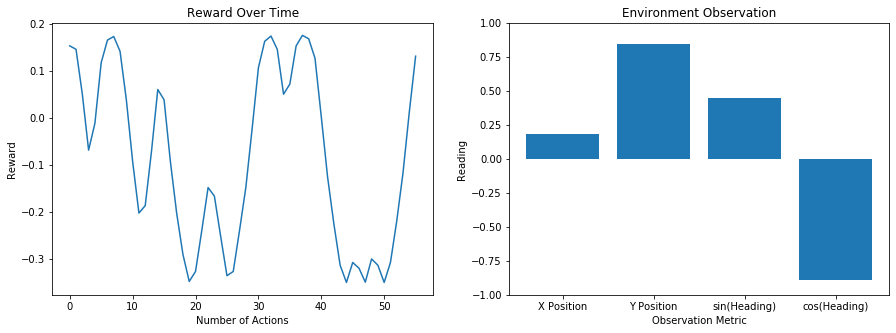

In [7]:
# Reset environment
env.reset()

# Init variables
counter = 0
rewards = []
done = False

# Create a random set of actions
actions = [Directions.S.value,
           Directions.SE.value,
           Directions.E.value,
           Directions.NE.value,
           Directions.N.value,
           Directions.NW.value,
           Directions.W.value,
           Directions.SW.value]

# For a short time
while counter < 50 and not done:
    # Repeat each of the actions in the list
    for a in actions:
        # If we crash break
        if done == True:
            break
        # Count each step
        counter += 1
        # Step in the environment
        observation, r, done, info = env.step(a)
        # Append the rewards
        rewards.append(r)
        # Display the reward and observation
        live_reward_observation_plot(rewards, observation)

### Manually Completing the Task

Now that we know the car needs to drive clockwise around the track let us see if we can manually drive the car around the track. To do that, I create a loop that changes the direction based on the number of steps we have run. A better way to do this would be to check the observation and make changes based on that.

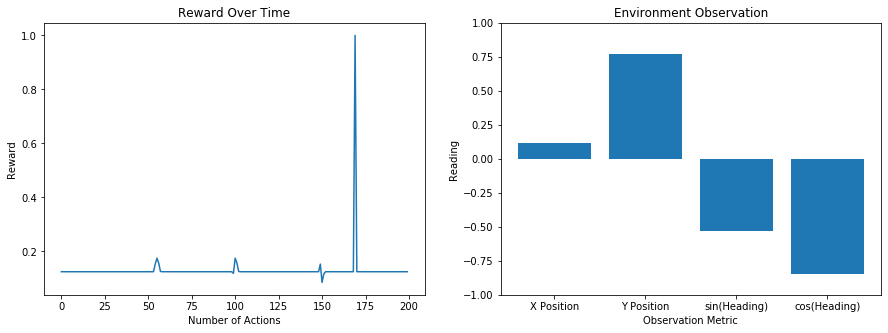

In [8]:
# Reset the environment
env.reset()
# Init variables
done = False
rewards = []
counter = 0
# While we are driving and have not crashed
while counter < 200 and not done:
    counter += 1
    # First drive north
    if counter < 55:
        observation, r, done, info = env.step(Directions.N.value)
    # Second drive east
    elif counter < 100:
        observation, r, done, info = env.step(Directions.E.value)
    # Third drive south
    elif counter < 150:
        observation, r, done, info = env.step(Directions.S.value)
    # Fourth drive west
    else:
        observation, r, done, info = env.step(Directions.W.value)
    # Display the values of the car driving
    rewards.append(r)
    live_reward_observation_plot(rewards, observation)

**Note**: The spike in reward is due to the car reaching its goal of going clockwise around the track.

# Reinforcement Learning

Now, let us run reinforcement learning on our environment to see if we can learn how to complete this task. First, let us import the libraries we need to complete this task.

In [9]:
import numpy as np
from env_road3 import Env 
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

Using TensorFlow backend.


Next, let us set a random seed so that it behaves the same on each run. **Note**: You should remove this line when running the final experiments.

In [10]:
np.random.seed(123)

### Creating the Model

Let us create the model using Keras (which we learned in class). The model takes in 4 inputs, which are the observations. The model needs to output the number of actions.

In [11]:
# Create an action space and observation space based on the expected size of both
nb_actions = len(Directions)
observation_space = (4,)

# Create our learning model.
model = Sequential()
# It takes in input of size observation_space
model.add(Flatten(input_shape=(1,) + observation_space))
# Three hidden layers
model.add(Dense(20))
model.add(Activation('relu'))
model.add(Dense(20))
model.add(Activation('relu'))
model.add(Dense(20))
model.add(Activation('relu'))
# Output layer with represents each of the possible directions
model.add(Dense(nb_actions))
model.add(Activation('linear'))
# Create that it keeps track of the agent’s experiences
memory = SequentialMemory(limit=500000, window_length=1)
# Q-values represent the components of the Boltzmann distribution
policy = BoltzmannQPolicy()
print ("model initiated")

model initiated


Next, we create the model. The model is passed onto **DQNAgent**, which trains the model based on the papers by Mnih (2013) and Mnih (2015). **DQNAgent** also handles the interaction with the environment. Due to the scope of this project, this has been abstracted. However, the general concept is you have both a feed-forward stage where you explore the world and then a feedback stage where you update your weights of your model based on your exploring. For more information, please look at:

* http://arxiv.org/pdf/1312.5602.pdf
* http://arxiv.org/abs/1509.06461

In [12]:
learning_rate=1e-3
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=50,
           target_model_update=1e-2, policy=policy,shield=None, huge_neg=False, preemptive=False)
dqn.compile(Adam(lr=learning_rate), metrics=['mae'])

Similarly to the section of testing our environment, we create a new function to plot the accumulated rewards.

In [13]:
def live_reward_plot(scores):
    # Create the figure
    plt.figure(figsize=(15, 5))
    plt.subplot(111)
    plt.subplot(1, 1, 1)
    # Plot the score
    plt.plot(scores)
    plt.title('Score Over Time')
    plt.xlabel("Number of Epochs")
    plt.ylabel("Score")
    plt.ylim([-5, 30])
    # Clear the current output
    clear_output(wait=True)
    # Show the plot
    plt.show()

### Training the Model

Lets now train the model to see how training works. Here we will request that the training be visualized so we can see what the reinforcement learning is doing. We will train the model for 100 steps. Here the steps are each action we apply to the model. Each time the model hits the wall, we notice that the model is reset due to the collision.

In [14]:
env.render(mode=True)
train_history = dqn.fit(env, nb_steps=100, visualize=True, verbose=0)

### Evaluation the Model

We now put the model in a loop where we train the model for 200 steps, and then we test the model. Each time we do this, we count this a single epoch. The accumulated score for the testing is then plotted as we go. We only run this for 5 epochs for time's sake. 

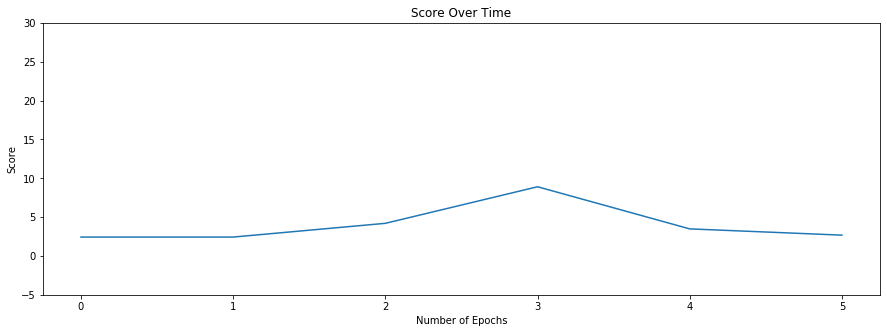

In [15]:
# Init the variables
score = 0
counter = 0
score_log = []

# Set the number of training steps and epochs
steps = 200
max_count = 5

# While we have not reached the max number of epochs
while counter <= max_count:
    counter += 1
    # Turn rending off for training
    env.render(mode=False)
    train_history = dqn.fit(env, nb_steps=steps, visualize=False, verbose=0)
    # Turn rending on for testing
    env.render(mode=True)
    test_history = dqn.test(env, nb_episodes=1, visualize=True, verbose=0)
    # Get and plot the score
    score = np.mean(test_history.history['episode_reward'])
    score_log.append(score)
    live_reward_plot(score_log)

# Shield

The shield is a unique part of this approach. A shield gets given a set of actions and then blocks certain actions from happening. Blocking certain actions allows the reinforcement learning agent to learn safely. Interesting, they implement their shield to take binary inputs. They never mention this in the paper and are simply an implementation choice.

### Auxilary Functions

The robots states and binary representation are shown below for convience. I created a function to decode these states for better human readability.

| State | Binary | Integer |
|-------|--------|---------|
|    Mid                    |    0000    |    0      |
|    right facing up        |    0001    |    1      |
|    left                   |    0010    |    2      |
|    bottom facing right    |    0011    |    3      |
|    top facing right       |    0100    |    4      |
|    top left facing up     |    0101    |    5      |
|    bot left facing bot    |    0101    |    5      |
|    bot left               |    0110    |    6      |
|    bot right              |    0110    |    6      |
|    bot right facing bot   |    0111    |    7      |
|    top right              |    0111    |    7      |
|    na                     |    1000    |    8      |
|    right                  |    1001    |    9      |
|    left facing up         |    1010    |    10     |
|    bottom                 |    1011    |    11     |
|    top                    |    1100    |    12     |
|    top right facing right |    1101    |    13     |
|    na                     |    1110    |    14     |
|    na                     |    1111    |    15     |

In [16]:
def decode_binary_observation(b):
    if   np.array_equal(np.array(b), np.array([0,0,0,0])):
        print("Mid")
    elif np.array_equal(np.array(b), np.array([0,0,0,1])):
        print("right facing up")
    elif np.array_equal(np.array(b), np.array([0,0,1,0])):
        print("left")
    elif np.array_equal(np.array(b), np.array([0,0,1,1])):
        print("bottom facing righ")
    elif np.array_equal(np.array(b), np.array([0,1,0,0])):
        print("top facing right")
    elif np.array_equal(np.array(b), np.array([0,1,0,1])):
        print("top left facing up or bot left facing bot")
    elif np.array_equal(np.array(b), np.array([0,1,1,0])):
        print("bot left or bot right")
    elif np.array_equal(np.array(b), np.array([0,1,1,1])):
        print("bot right facing bot or top right")
    elif np.array_equal(np.array(b), np.array([1,0,0,0])):
        print("na")
    elif np.array_equal(np.array(b), np.array([1,0,0,1])):
        print("right")
    elif np.array_equal(np.array(b), np.array([1,0,1,0])):
        print("left facing up")
    elif np.array_equal(np.array(b), np.array([1,0,1,1])):
        print("bottom")
    elif np.array_equal(np.array(b), np.array([1,1,0,0])):
        print("top")
    elif np.array_equal(np.array(b), np.array([1,1,0,1])):
        print("top right facing right")
    elif np.array_equal(np.array(b), np.array([1,1,1,0])):
        print("na")
    elif np.array_equal(np.array(b), np.array([1,1,1,1])):
        print("na")
    else:
        print("Unknown number")

Next, they declare a function that takes in a value and converts it to binary format. They pad it with 0's.

In [17]:
# To binary
def to_bin(x):
    x = "{0:b}".format(x)
    x = list(map(int,x))
    x = [0 for s in range(3-len(x))] + x
    return x

Here they declare a function which takes binary input and converts it to an integer

In [18]:
# Bianry to int
def to_int(x):
    x__,_x_,__x = x
    return 4*x__+2*_x_+1*__x

### Shielding

The shield then takes in a binary representation of the actions. It also takes in a binary representation of the state. They compute which actions are not allowed based on these two representations. Below is an example of that working

In [19]:
# Reset the environment
env.reset()
observation, r, done, info = env.step(Directions.N.value)

Lets create a shield. The shield is implemented to take in an observation and an action both in binary format. It then returns if the action is rejected or not.

In [20]:
from safelearn2 import Shield
shield = Shield()

Take an observation and convert it into a binary format. This is the format which is used by the shield

In [21]:
from rl.core import get_input
o_bin = get_input(observation)
print(o_bin)
decode_binary_observation(o_bin)

(1, 0, 1, 0)
left facing up


Finally for each of the actions, check if the shield rejects it or not based on the current observation. We can then take each of the banned actions and print them out. These actions would then be rejected if the reinforcement learning agent tried to select them.

In [22]:
# Create a list of banned actions
banned_actions = []
# For each action
for an_action in range(0,8):
    # Convert the action into a binary format
    a_bin = to_bin(an_action)
    # Pass the action and the observation to the shield
    action = to_int(shield.move(o_bin[0],o_bin[1],o_bin[2],o_bin[3],a_bin[0],a_bin[1],a_bin[2]))
    # If the action is not an action (i.e the sheild rejected it)
    if action != an_action:
        # Add this action to banned actions
        banned_actions.append(an_action)

# Print out the list of banned actions
print("Banned Actions: ")
print(banned_actions)
for ba in banned_actions:
    print(get_direction_from_value(ba))

Banned Actions: 
[0, 1, 5, 6, 7]
Directions.S
Directions.SE
Directions.NW
Directions.W
Directions.SW


# Putting it Together

Finally we add both the reinforcement learning and the shield together. This creates a reinforcement learning agent which is being shielded from doing dangerous actions. Let us start by first resetting the environment.

In [23]:
# Reset the environment
env.reset()
observation, r, done, info = env.step(Directions.N.value)

Lets create a shield as we have done before.

In [24]:
shield = Shield()

Create a DQNAgent as done before. However here lets pass in the shield and set preemptive to true

In [25]:
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=50,
           target_model_update=1e-2, policy=policy,shield=shield, huge_neg=False, preemptive=True)

Now lets compile our agent with a learning rate set to 1e-3

In [26]:
learning_rate = 1e-3
dqn.compile(Adam(lr=learning_rate), metrics=['mae'])

Lets visualize the first 100 steps of training and compare them to how reinforcement learning did without the shield. Remember that without the shield the vechile was crashing during the training phase.

In [27]:
env.render(mode=True)
train_history = dqn.fit(env, nb_steps=100, visualize=True, verbose=0)

Finally lets repeat the same test with the vehicle we will let it train for 5 epochs and compare the vehicles ability with and without the shield. We notice that with the shield the vehicle does not crash and thus performs much better than a vehicle without a shield

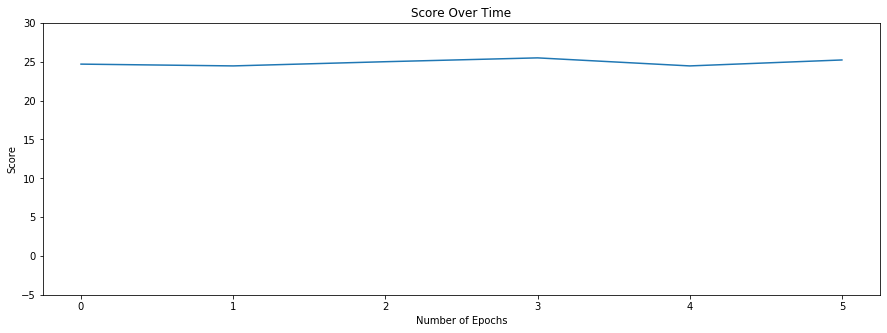

In [28]:
# Init the variables
score = 0
counter = 0
score_log = []

# Set the number of training steps and epochs
steps = 200
max_count = 5

# While we have not reached the max number of epochs
while counter <= max_count:
    counter += 1
    # Turn rending off for training
    env.render(mode=False)
    train_history = dqn.fit(env, nb_steps=steps, visualize=False, verbose=0)
    # Turn rending on for testing
    env.render(mode=True)
    test_history = dqn.test(env, nb_episodes=1, visualize=True, verbose=0)
    # Get and plot the score
    score = np.mean(test_history.history['episode_reward'])
    score_log.append(score)
    live_reward_plot(score_log)